## Data Source
<a href='https://www.kaggle.com/datasets/kazanova/sentiment140'>Kaggle Twitter Sentiment Dataset</a>

## Data Analysis

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('data/tweets.csv',names=['label','id','date','status','user','text'])

In [3]:
df.head()

,label,id,date,status,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   status  1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
df['label'].value_counts()

label
0    800000
4    800000
Name: count, dtype: int64

## Data Visualization

In [6]:
import seaborn as sns

<Axes: xlabel='label', ylabel='count'>

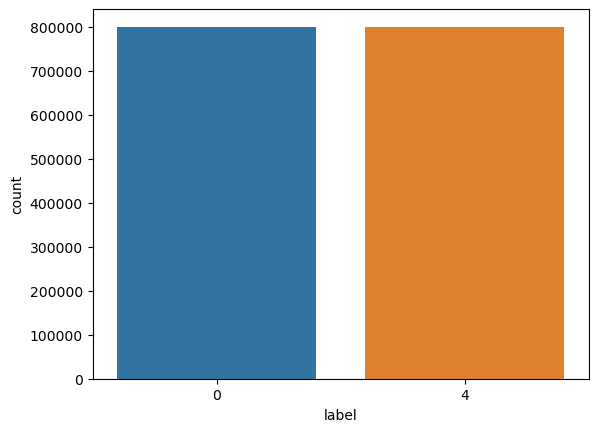

In [7]:
sns.countplot(x='label',data=df)

## Preprocessing

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [9]:
spark = SparkSession.builder.appName('TwitterSentimentAnalysis').getOrCreate()

In [10]:
schema = StructType([
    StructField('label',IntegerType(),True),
    StructField('id',StringType(),True),
    StructField('date',StringType(),True),
    StructField('status',StringType(),True),
    StructField('user',StringType(),True),
    StructField('text',StringType(),True)
])

In [11]:
data = spark.read.csv('data/tweets.csv',schema=schema,header=False)
data = data.sample(withReplacement=False,fraction=0.01)

In [12]:
tokenizer = Tokenizer(inputCol='text',outputCol='words')  

In [13]:
words_data = tokenizer.transform(data)

In [14]:
remover = StopWordsRemover(inputCol='words',outputCol='filtered_words')

In [15]:
filtered_data = remover.transform(words_data)

In [16]:
texts = [row['filtered_words'] for row in filtered_data.select('filtered_words').collect()]

In [17]:
keras_tokenizer = KerasTokenizer(num_words=10000,oov_token='<OOV>')

In [18]:
keras_tokenizer.fit_on_texts(texts)

In [19]:
sequences = keras_tokenizer.texts_to_sequences(texts)

In [20]:
padded_sequences = pad_sequences(sequences,maxlen=100,padding='post',truncating='post')

In [21]:
labels = [row['label'] // 4 for row in filtered_data.select('label').collect()]
labels = np.array(labels).reshape((len(labels),1))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.1)

## Training

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [24]:
model = Sequential([
    Embedding(input_dim=10000,output_dim=64,input_length=100),
    LSTM(64),
    Dense(1,activation='sigmoid')
])

In [25]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [27]:
model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10)

Epoch 1/10
407/407 [==============================] - 24s 52ms/step - loss: 0.6933 - accuracy: 0.5039 - val_loss: 0.6939 - val_accuracy: 0.4914
Epoch 2/10
407/407 [==============================] - 19s 48ms/step - loss: 0.6933 - accuracy: 0.5042 - val_loss: 0.6931 - val_accuracy: 0.5086
Epoch 3/10
407/407 [==============================] - 17s 43ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6933 - val_accuracy: 0.4914
Epoch 4/10
407/407 [==============================] - 19s 46ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.4914
Epoch 5/10
407/407 [==============================] - 18s 44ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6933 - val_accuracy: 0.4914
Epoch 6/10
407/407 [==============================] - 18s 43ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6934 - val_accuracy: 0.4914
Epoch 7/10
407/407 [==============================] - 21s 51ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6932 - val_accuracy:

In [28]:
model.save('lstm_model')

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


## Evaluation

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
predictions = model.predict(X_test)

51/51 [==============================] - 1s 16ms/step


In [31]:
predictions = predictions.reshape(-1) >= 0.5
y_test = y_test.reshape(-1)

In [32]:
accuracy = accuracy_score(y_test,predictions)
print(f'Test Accuracy: {accuracy*100:.2f}%')

Test Accuracy: 49.19%
